<h1 align="center">Wine Prediction</h1>

<div align="center"><img src="https://static01.nyt.com/images/2020/01/30/dining/30pour/30pour-superJumbo.jpg?quality=90&auto=webp" width=60%></div>
<h1 align="center"></h1>
<div style="text-align: justify">&emsp;&emsp;Wine merupakan sebuah minuman beralkohol yang dikonsumsi oleh kalangan menengah keatas. Wine tersebut memiliki rasa yang berbeda-beda dengan harga yang berbeda pula. Oleh karena itu mari kita mencoba membuat beberapa machine learning untuk memprediksi harga dari data yang ada. Tapi sebelumnya, mari kita melakukan Exploratory Data Analisis</div>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.sparse import hstack
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

<div style="text-align: justify">&emsp;&emsp;Pertama-tama, mari kita mencari korelasi antara beberapa variabel. Kita memerlukan beberapa variabel yang mempengaruhi data harga dari wine yang beredar di pasaran. Sebelum melakukan itu, mari kita mengimport data dan mengencode beberapa kategori yang dibutuhkan menjadi angka.</div>

In [2]:
wineDFRaw = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
wineDF = wineDFRaw[['country','points', 'price', 'province', 'variety', 'winery', 'taster_name', 'description']]
wineDF.head(10)

,country,points,price,province,variety,winery,taster_name,description
0,Italy,87,NaN,Sicily & Sardinia,White Blend,Nicosia,Kerin O’Keefe,"Aromas include tropical fruit, broom, brimston..."
1,Portugal,87,15.0,Douro,Portuguese Red,Quinta dos Avidagos,Roger Voss,"This is ripe and fruity, a wine that is smooth..."
2,US,87,14.0,Oregon,Pinot Gris,Rainstorm,Paul Gregutt,"Tart and snappy, the flavors of lime flesh and..."
3,US,87,13.0,Michigan,Riesling,St. Julian,Alexander Peartree,"Pineapple rind, lemon pith and orange blossom ..."
4,US,87,65.0,Oregon,Pinot Noir,Sweet Cheeks,Paul Gregutt,"Much like the regular bottling from 2012, this..."
5,Spain,87,15.0,Northern Spain,Tempranillo-Merlot,Tandem,Michael Schachner,Blackberry and raspberry aromas show a typical...
6,Italy,87,16.0,Sicily & Sardinia,Frappato,Terre di Giurfo,Kerin O’Keefe,"Here's a bright, informal red that opens with ..."
7,France,87,24.0,Alsace,Gewürztraminer,Trimbach,Roger Voss,This dry and restrained wine offers spice in p...
8,Germany,87,12.0,Rheinhessen,Gewürztraminer,Heinz Eifel,Anna Lee C. Iijima,Savory dried thyme notes accent sunnier flavor...
9,France,87,27.0,Alsace,Pinot Gris,Jean-Baptiste Adam,Roger Voss,This has great depth of flavor with its fresh ...


In [3]:
wineDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   points       129971 non-null  int64  
 2   price        120975 non-null  float64
 3   province     129908 non-null  object 
 4   variety      129970 non-null  object 
 5   winery       129971 non-null  object 
 6   taster_name  103727 non-null  object 
 7   description  129971 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 8.9+ MB


<div style="text-align: justify">&emsp;&emsp;Berhubung dalam komentar kernel author diberi tahu bahwa ada beberapa jenis buah yang menggunakan bahasa German, Spanyol, Italia, dan Portugis, maka lebih baik kita mengkonversinya terlebih dahulu agar dataset menjadi lebih akurat. Selain itu, kita harus drop row yang memiliki nilai NaN agar data menjadi lebih "bersih"</div>

In [4]:
wineDF.loc[:, 'variety'] = wineDF.loc[:, 'variety'].replace(['weissburgunder'], 'chardonnay')
wineDF.loc[:, 'variety'] = wineDF.loc[:, 'variety'].replace(['spatburgunder'], 'pinot noir')
wineDF.loc[:, 'variety'] = wineDF.loc[:, 'variety'].replace(['grauburgunder'], 'pinot gris')
wineDF.loc[:, 'variety'] = wineDF.loc[:, 'variety'].replace(['garnacha'], 'grenache')
wineDF.loc[:, 'variety'] = wineDF.loc[:, 'variety'].replace(['pinot nero'], 'pinot noir')
wineDF.loc[:, 'variety'] = wineDF.loc[:, 'variety'].replace(['alvarinho'], 'albarino')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
wineDF = wineDF.dropna()
wineDF.head()

,country,points,price,province,variety,winery,taster_name,description
1,Portugal,87,15.0,Douro,Portuguese Red,Quinta dos Avidagos,Roger Voss,"This is ripe and fruity, a wine that is smooth..."
2,US,87,14.0,Oregon,Pinot Gris,Rainstorm,Paul Gregutt,"Tart and snappy, the flavors of lime flesh and..."
3,US,87,13.0,Michigan,Riesling,St. Julian,Alexander Peartree,"Pineapple rind, lemon pith and orange blossom ..."
4,US,87,65.0,Oregon,Pinot Noir,Sweet Cheeks,Paul Gregutt,"Much like the regular bottling from 2012, this..."
5,Spain,87,15.0,Northern Spain,Tempranillo-Merlot,Tandem,Michael Schachner,Blackberry and raspberry aromas show a typical...


In [6]:
wineDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96420 entries, 1 to 129970
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      96420 non-null  object 
 1   points       96420 non-null  int64  
 2   price        96420 non-null  float64
 3   province     96420 non-null  object 
 4   variety      96420 non-null  object 
 5   winery       96420 non-null  object 
 6   taster_name  96420 non-null  object 
 7   description  96420 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 6.6+ MB


<div style="text-align: justify">Sekarang mari kita melakukan beberapa Exploratory Data Analisis.</div>

In [7]:
wineDF[['points','price']].describe()

,points,price
count,96420.000000,96420.000000
mean,88.585625,35.005009
std,2.951817,43.069060
min,80.000000,4.000000
25%,87.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,40.000000
max,100.000000,3300.000000


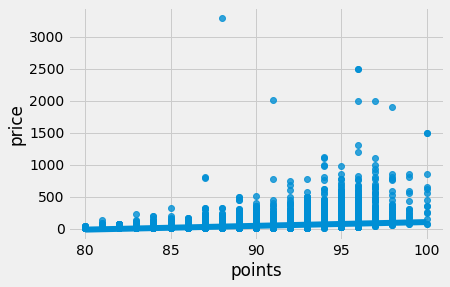

In [8]:
plt.style.use('fivethirtyeight')
sns.regplot(wineDF['points'], wineDF['price'])

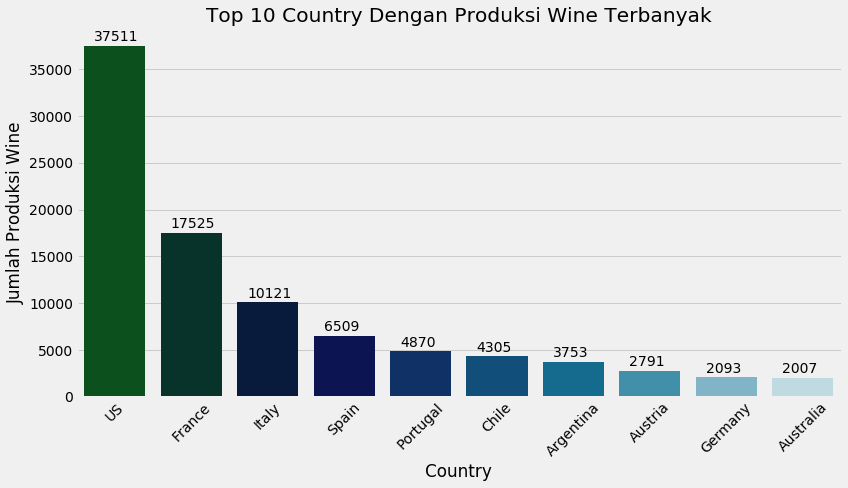

In [9]:
g = sns.catplot(x='country', data=wineDF, kind='count', order=pd.value_counts(wineDF['country']).iloc[:10].index, palette= 'ocean')
g.ax.set_title('Top 10 Country Dengan Produksi Wine Terbanyak')
g.set(xlabel= 'Country', ylabel='Jumlah Produksi Wine')
g.fig.set_size_inches([12,7])
g.set_xticklabels(rotation=45)
for p in g.ax.patches:
    g.ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()+500))
plt.tight_layout()

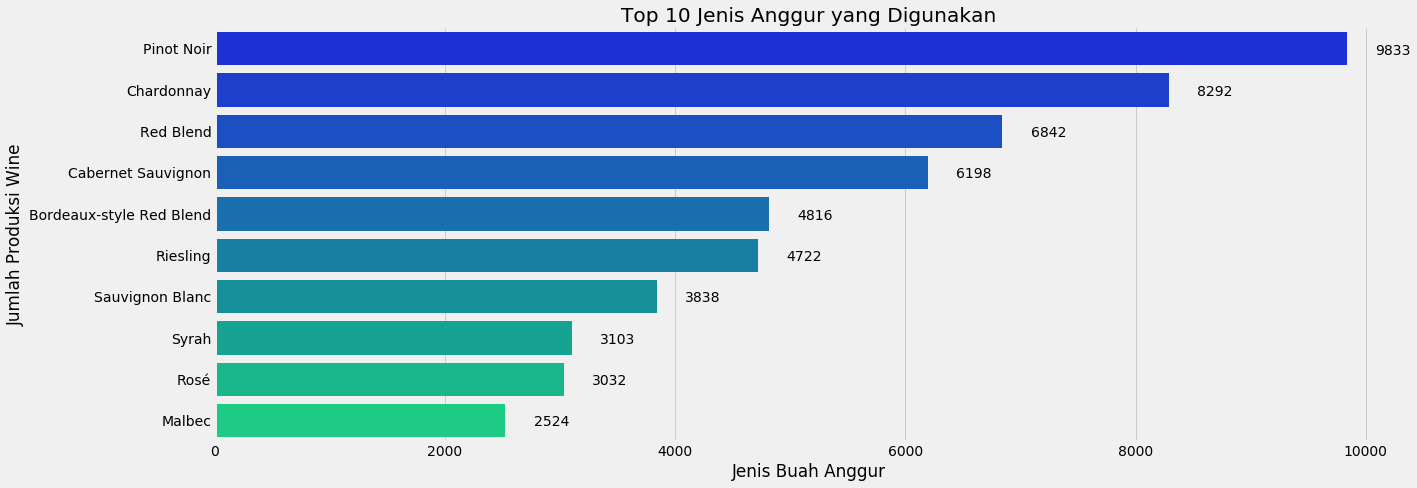

In [10]:
g = sns.catplot(y='variety', data=wineDF, kind='count', order=pd.value_counts(wineDF['variety']).iloc[:10].index, palette= 'winter')
g.ax.set_title('Top 10 Jenis Anggur yang Digunakan')
g.set(xlabel= 'Jenis Buah Anggur', ylabel='Jumlah Produksi Wine')
g.fig.set_size_inches([20,7])
for p in g.ax.patches:
    width = p.get_width()
    plt.text(400+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:.0f}'.format(width),
             ha='center', va='center')
plt.tight_layout()

In [11]:
wineDF[['variety', 'points', 'price']].groupby("variety").agg(['mean', 'median', 'min', 'max','count'])

points                           price                      \
                  mean median min max count       mean median   min    max   
variety                                                                      
Abouriou     87.666667   87.0  85  91     3  35.000000   15.0  15.0   75.0   
Agiorgitiko  87.031746   87.0  83  92    63  23.571429   20.0  10.0   66.0   
Aglianico    89.598870   90.0  81  97   177  39.564972   34.0   6.0  180.0   
Aidani       82.000000   82.0  82  82     1  27.000000   27.0  27.0   27.0   
Airen        81.666667   82.0  80  83     3   9.000000    9.0   8.0   10.0   
...                ...    ...  ..  ..   ...        ...    ...   ...    ...   
Zinfandel    88.591746   89.0  80  97  1575  29.844444   28.0   6.0  100.0   
Zlahtina     86.000000   86.0  84  88     2  14.500000   14.5  13.0   16.0   
Zweigelt     88.500000   89.0  82  94   182  21.516484   18.0   9.0   70.0   
Çalkarası    86.500000   86.5  86  87     2  19.000000   19.0  19.0   19.0   
Žilavka      88.000000   88.0  88  88     1  15.000000   15.0  15.0   15.0   

                   
            count  
variety            
Abouriou        3  
Agiorgitiko    63  
Aglianico     177  
Aidani          1  
Airen           3  
...           ...  
Zinfandel    1575  
Zlahtina        2  
Zweigelt      182  
Çalkarası       2  
Žilavka         1  

[653 rows x 10 columns]

In [12]:
def getKualitas(points):
    if(points <= 85):
        return 'Buruk'
    elif(points<=90 ):
        return 'Ok'
    elif(points<=95):
        return 'Enak'
    elif(points<=100):
        return 'Sangat Enak'
    else:
        return 'Cek code lagi! Ada yang salah'

In [13]:
wineDF['kualitas'] = wineDF['points'].apply(getKualitas)

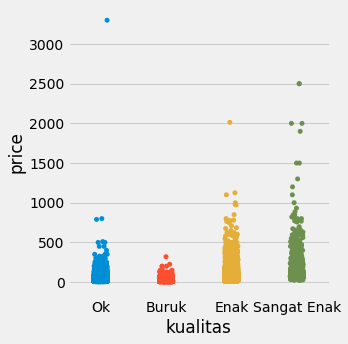

In [14]:
sns.catplot(x = 'kualitas', y = 'price', data = wineDF)

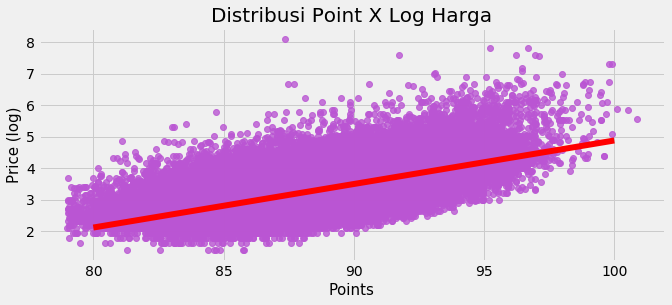

In [15]:
plt.figure(figsize=(10,4))

wineDF.loc[:, 'price_log'] = np.log(wineDF.loc[:, 'price'])

g = sns.regplot(x='points', y='price_log', 
                data=wineDF, line_kws={'color':'red'},
                x_jitter=True, fit_reg=True, color='mediumorchid')
g.set_title("Distribusi Point X Log Harga", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price (log)", fontsize= 15)

plt.show()

<div style="text-align: justify">&emsp;&emsp;Lalu, mari kita membuat hipotesis awal. Kira-kira, manakah yang mungkin memiliki korelasi signifikan terhadap harga wine? Untuk itu, kita perlu untuk mengetahuinya menggunakan statsmodel. Mari kita asumsikan bahwa point yang didapat berpengaruh signifikan terhadap harga wine.</div>

In [16]:
X = wineDF['points']
y = wineDF['price']

corCoef, pvalue = pearsonr(X, y)
print(corCoef)
print('%0.3f' % pvalue)

if pvalue <= 0.05:
    print('Korelasi antara point dengan harga signifikan')
else:
    print('Korelasi antara point dengan harga tidak signifikan')

0.4040017582872987
0.000
Korelasi antara point dengan harga signifikan


<div style="text-align: justify">&emsp;&emsp;Berdasarkan teori statistik, dari code diatas dapat disimpulkan bahwa point dan harga memiliki korelasi. Bila harga wine semakin meningkat, maka kemungkinan juga harga akan meningkat. Oleh karena itu, mari kita membuat machine learning untuk memprediksi kualitas wine dari data harga wine.</div>

In [17]:
X = wineDF[['price']]
y = wineDF['kualitas']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# Train model
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Test model
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = accuracy*100
print('%0.2f' % accuracy,'%')

64.44 %


Mari kita bandingkan actual dengan hasil predictionnya

In [18]:
df = pd.DataFrame({'actual': y_test, 'prediction': y_pred})
df.head(10)

,actual,prediction
109284,Enak,Enak
107439,Ok,Enak
31171,Ok,Ok
108103,Ok,Ok
124719,Ok,Ok
13660,Ok,Ok
17250,Buruk,Ok
1833,Buruk,Ok
49597,Ok,Ok
59078,Ok,Ok


In [21]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

# Test model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = accuracy*100
print('%0.2f' % accuracy,'%')

60.36 %


In [22]:
df = pd.DataFrame({'actual': y_test, 'prediction': y_pred})
df.head(10)

,actual,prediction
109284,Enak,Enak
107439,Ok,Enak
31171,Ok,Ok
108103,Ok,Enak
124719,Ok,Ok
13660,Ok,Ok
17250,Buruk,Ok
1833,Buruk,Ok
49597,Ok,Ok
59078,Ok,Ok


<h1 align="center">Final Accuracy: 64,44%</h1>
<div style="text-align: justify">&emsp;&emsp;Kita mengambil accuracy yang terbesar dari 2 library yang digunakan. Bila dilihat dari tingkat akurasi prediksi dari 2 machine learning model diatas, maka dapat disimpulkan bahwa akurasi dari machine learning tersebut masih kurang. Untuk itu, mari kita melihat dari sudut pandang lain. Bagaimana kalau menambah variabel penentu (harga) dengan reviewnya? Apakah akurasinya bisa menjadi lebih bagus? Tapi sebelum itu kita perlu menghilangkan stopwords pada description.</div>

In [78]:
X = wineDF[['description', 'price']]
stop = set(stopwords.words('english'))
extras = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'cab',"%"]
stop.update(extras)

In [79]:
vect = CountVectorizer(stop_words = stop)
X_dtm = vect.fit_transform(X.description)
price = X.price.values[:,None]
X_dtm = hstack((X_dtm, price))

In [80]:
y = wineDF['kualitas']

X_train, X_test, y_train, y_test = train_test_split(X_dtm, y, random_state=42, test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(86778, 26288) (9642, 26288) (86778,) (9642,)


In [81]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = accuracy*100
print('%0.2f' % accuracy,'%')

76.85 %


In [82]:
df = pd.DataFrame({'actual': y_test, 'prediction': y_pred})
df.head(10)

,actual,prediction
109284,Enak,Ok
107439,Ok,Ok
31171,Ok,Ok
108103,Ok,Ok
124719,Ok,Ok
13660,Ok,Ok
17250,Buruk,Buruk
1833,Buruk,Buruk
49597,Ok,Ok
59078,Ok,Ok


<h1 align="center">Final Accuracy: 76,85%</h1>
<div style="text-align: justify">&emsp;&emsp;Dari hasil code diatas, dapat kita lihat bahwa hasil train dengan menggunakan data review dan harga dapat menentukan kualitas dari wine dengan lebih baik dengan tingkat akurasi 76.85%. Kesimpulannya adalah untuk memprediksi kualitas dari wine, kita dapat menggunakan review deskriptif dari reviewer dan juga harga wine tersebut, karena memiliki akurasi yang lebih tinggi daripada yang menggunakan harga saja.</div>
<h1 align="center">Menyimpan Machine Learning Model</h1>
<div style="text-align: justify">Kita sudah menemukan model machine learning dengan akurasi yang cukup baik. Sekarang, mari kita menyimpan dalam sebuah file.</div>

In [83]:
import joblib

# save model sebagai pickle dalam file
joblib.dump(lr, 'MachineLearningModel.pkl')

['MachineLearningModel.pkl']